## Incerteza nos Dados MNIST

In [1]:
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import numpy as np
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt
plt.style.use("ggplot")

Using TensorFlow backend.


A seguir, baixamos e processamos os dados. Nosso modelo vai aprender a distinguir 5 de 3. Também vamos salvar os 4 para mostrar depois ao nosso modelo e ver como ele se comporta ao ser forçado a prever um 4 como sendo um 5 ou 3.

In [2]:
# get the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_strange = x_train[y_train == 4]
y_strange = y_train[y_train == 4]

x_train = x_train[np.logical_or(y_train == 3, y_train == 5)]
y_train = y_train[np.logical_or(y_train == 3, y_train == 5)]

x_test = x_test[np.logical_or(y_test == 3, y_test == 5)]
y_test = y_test[np.logical_or(y_test == 3, y_test == 5)]

x_strange = x_strange[:x_test.shape[0]]
y_strange = y_strange[:x_test.shape[0]]

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)
x_strange = x_strange.reshape(-1, 784)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_strange = x_strange.astype('float32')

x_train /= 255
x_test /= 255
x_strange /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_strange.shape[0], 'strange samples')

11552 train samples
1902 test samples
1902 strange samples


Convertemos o alvo em binário. 1 será 3 e 0 será 5. Assim, nosso modelo nos dará a probabilidade da imagem ser um 3.

In [3]:
# convert class vectors to binary class matrices
y_train = (y_train == 3).astype(int)
y_test = (y_test == 3).astype(int)

In [4]:
y_test.mean()

0.53101997896950581

Criamos a rede neural com duas camadas ocultas, *Dropout* após cada camada oculta e apos a camada de entrada.

In [5]:
batch_size = 128
num_classes = 1
epochs = 10

model = Sequential()
model.add(Dropout(0.5, input_shape=(784,)))
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 665,089
Trainable params: 665,089
Non-trainable params: 0
_________________________________________________________________


Treinamos o modelo

In [6]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 11552 samples, validate on 1902 samples
Epoch 1/10
11552/11552 [==============================] - 3s - loss: 0.2471 - acc: 0.8919 - val_loss: 0.0746 - val_acc: 0.9716
Epoch 2/10
11552/11552 [==============================] - 2s - loss: 0.1341 - acc: 0.9488 - val_loss: 0.0547 - val_acc: 0.9779
Epoch 3/10
11552/11552 [==============================] - 2s - loss: 0.1147 - acc: 0.9558 - val_loss: 0.0455 - val_acc: 0.9879
Epoch 4/10
11552/11552 [==============================] - 2s - loss: 0.0965 - acc: 0.9641 - val_loss: 0.0386 - val_acc: 0.9853
Epoch 5/10
11552/11552 [==============================] - 2s - loss: 0.0788 - acc: 0.9711 - val_loss: 0.0344 - val_acc: 0.9905
Epoch 6/10
11552/11552 [==============================] - 2s - loss: 0.0689 - acc: 0.9745 - val_loss: 0.0314 - val_acc: 0.9895
Epoch 7/10
11552/11552 [==============================] - 3s - loss: 0.0714 - acc: 0.9737 - val_loss: 0.0334 - val_acc: 0.9879
Epoch 8/10
11552/11552 [==============================] - 3s -

In [7]:
score

[0.027932440640735828, 0.99263932683615774]

## Incerteza
Realizamos 1000 *forward-passes* pela rede neural para obter 1000 previsões para cada amostra.

In [8]:
T = 1000
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

Yt_hat = np.array([predict_stochastic([x_test, 1]) for _ in range(T)])
y_hat_stocastic_test = Yt_hat.reshape(-1,y_test.shape[0]).T

Computamos a probabilidade média de cada amostra como sendo a previsão do modelo com Monte-Carlo *Dropout*

In [9]:
y_mean_test = np.mean(y_hat_stocastic_test, axis=1)

In [10]:
metrics.accuracy_score(y_true=y_test, y_pred=y_mean_test > .5)

0.99158780231335442

### Métricas de Incerteza

De http://www.cs.ox.ac.uk/people/yarin.gal/website/thesis/thesis.pdf, página 51.

In [11]:
# Desvio padrão
y_std_test = np.std(y_hat_stocastic_test, axis=1)

In [12]:
# variational ratio
y_mode = (np.mean(y_hat_stocastic_test > .5, axis=1) > .5).astype(int).reshape(-1,1)
vr = 1 - np.mean((y_hat_stocastic_test > .5) == y_mode, axis=1)

In [13]:
test_analysis = pd.DataFrame({
    "y_true": y_test,
    "y_hat": y_mean_test,
    "VR": vr,
    "STD": y_std_test
})

Analisamos algumas estatísticas gerais de incerteza na base de teste. Note que, em média, as probabilidades previstas têm uma dispersão de 5% e a incerteza máxima é 0.36.

In [14]:
test_analysis.describe()

,STD,VR,y_hat,y_true
count,1902.000000,1902.000000,1.902000e+03,1902.000000
mean,0.055957,0.021917,5.285388e-01,0.531020
std,0.075827,0.068223,4.707736e-01,0.499168
min,0.000008,0.000000,6.897094e-07,0.000000
25%,0.005340,0.000000,3.340063e-03,0.000000
50%,0.023496,0.000000,8.382964e-01,1.000000
75%,0.071425,0.005000,9.941828e-01,1.000000
max,0.361642,0.498000,9.999955e-01,1.000000


In [15]:
test_analysis.dropna(inplace=True)

Podemos plotar incerteza contra a probabilidade para mostrar que elas não são a mesma coisa. Claro que elas estão relacionadas, mas veja como há amostras cuja previsão de ser um 3 são 80%, mas incertezas variando de 0.15 até 0.25 (pontos azuis).

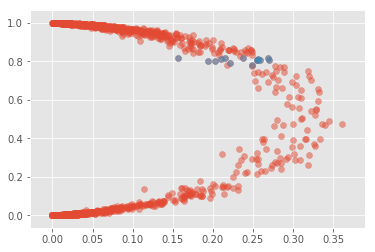

In [37]:
plt.scatter(test_analysis.STD, test_analysis.y_hat, alpha=.5)
plt.scatter(test_analysis.STD[(test_analysis.y_hat < .82) & (test_analysis.y_hat > .78)],
            test_analysis.y_hat[(test_analysis.y_hat < .82) & (test_analysis.y_hat > .78)], alpha=.5)
plt.show()

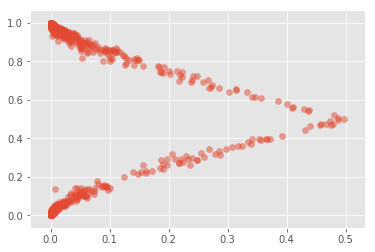

In [17]:
plt.scatter(test_analysis.VR, test_analysis.y_hat, alpha=.5)
plt.show()

## Incerteza nos Casos Estranhos
Realizamos o mesmo experimento acima, mas agora nas amostras correspondentes ao número 4 (lembre-se de que o modelo é treinado só em 5s e 3s).

In [18]:
T = 1000
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

Yt_hat = np.array([predict_stochastic([x_strange, 1]) for _ in range(T)])
y_hat_stocastic_strange = Yt_hat.reshape(-1,y_strange.shape[0]).T

In [19]:
# mean
y_mean_strange = np.mean(y_hat_stocastic_strange, axis=1)

In [20]:
# STD
y_std_strange = np.std(y_hat_stocastic_strange, axis=1)

In [21]:
# variational ratio
y_mode = (np.mean(y_hat_stocastic_strange > .5, axis=1) > .5).astype(int).reshape(-1,1)
vr = 1 - np.mean((y_hat_stocastic_strange > .5) == y_mode, axis=1)

In [22]:
strange_analysis = pd.DataFrame({
    "y_true": y_strange,
    "y_hat": y_mean_strange,
    "VR": vr,
    "STD": y_std_strange
    
})

Nesse caso, a incerteza média é .27, ou seja, muito maior do que a observada nos casos normais (0.05). A incerteza máxima também é maior, .39, mas não tanto (a nos dados normais era .36).

In [38]:
strange_analysis.describe()

,STD,VR,y_hat,y_true
count,1902.000000,1902.000000,1902.000000,1902.0
mean,0.272515,0.258376,0.504283,4.0
std,0.067588,0.143424,0.242483,0.0
min,0.004459,0.000000,0.000641,4.0
25%,0.241394,0.135250,0.320320,4.0
50%,0.289588,0.264000,0.526099,4.0
75%,0.319736,0.379000,0.698148,4.0
max,0.398348,0.500000,0.998967,4.0


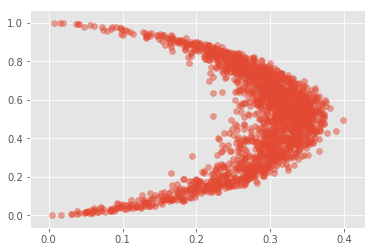

In [23]:
plt.scatter(strange_analysis.STD, strange_analysis.y_hat, alpha=.5)
plt.show()

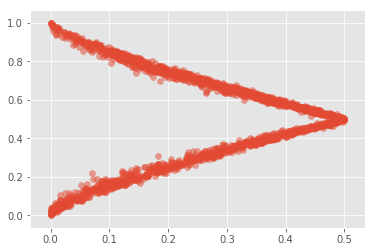

In [24]:
plt.scatter(strange_analysis.VR, strange_analysis.y_hat, alpha=.5)
plt.show()

## Comparando
Vamos agora comparar a incerteza do modelo nos exemplos que ele foi treinado e nos 4s que ele não viu durante o treinamento. 

Em primeiro lugar, vamos ver os casos em que o modelo está mais incerto, mas ainda sobre os 3 e 5 vistos durante o treino.

In [25]:
idx_uncertain = test_analysis.sort_values(by="STD", ascending=False).head().index
test_analysis.sort_values(by="STD", ascending=False).head()

,STD,VR,y_hat,y_true
974,0.361642,0.478,0.476791,1
1151,0.345366,0.473,0.489823,1
586,0.339706,0.456,0.467302,1
254,0.336519,0.467,0.476343,0
381,0.333458,0.366,0.398098,0


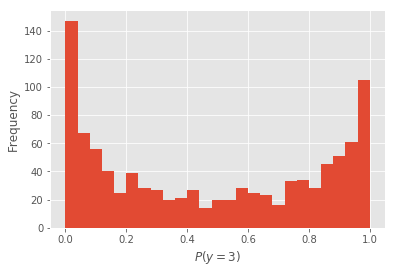

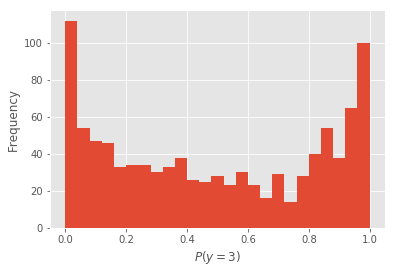

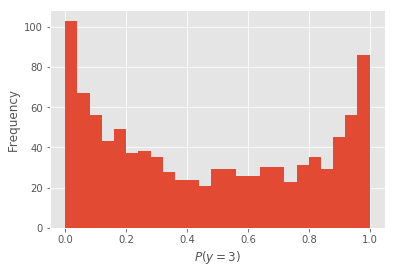

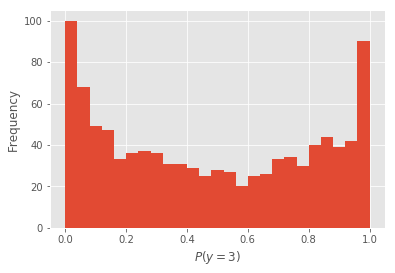

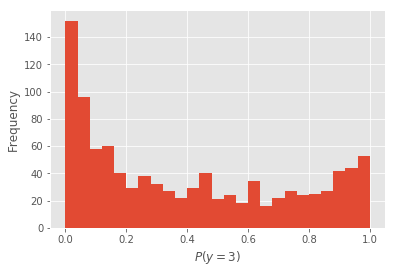

In [26]:
for i in idx_uncertain:
    plt.hist(y_hat_stocastic_test[i], bins=25)
    plt.xlabel("$P(y=3)$")
    plt.ylabel("Frequency")
    plt.show()

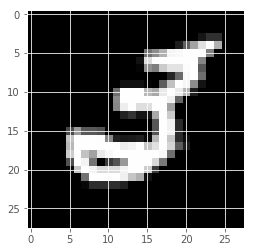

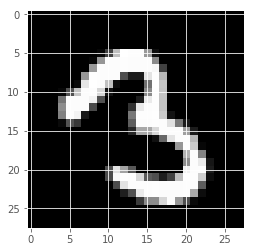

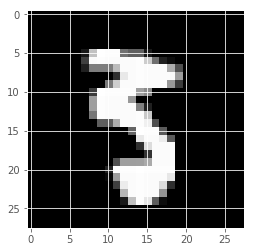

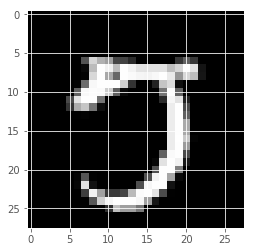

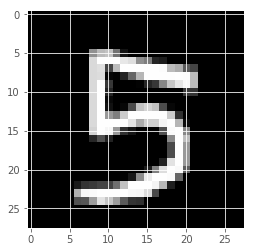

In [27]:
for i in idx_uncertain:
    plt.imshow(x_test[i].reshape(28,28), cmap="gray")
    plt.show()

Agora, vamos pegar as 5 primeiras amostras do set de teste e ver a incerteza nelas.

In [44]:
test_analysis.head(5)

,STD,VR,y_hat,y_true
0,0.001598,0.000,0.000265,0
1,0.103537,0.014,0.049077,0
2,0.139278,0.027,0.933923,1
3,0.000716,0.000,0.000118,0
4,0.007409,0.000,0.998539,1


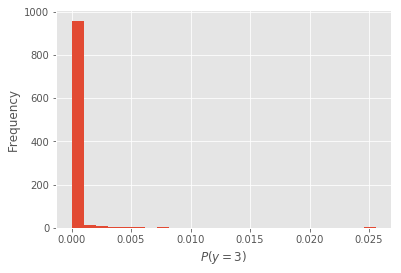

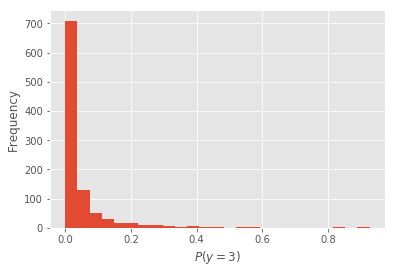

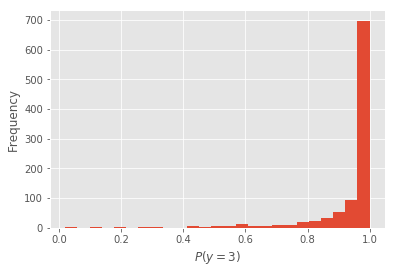

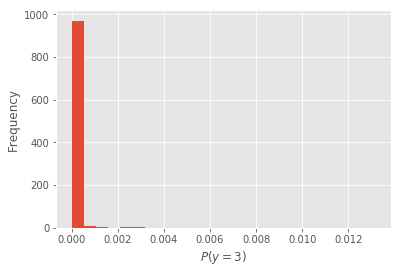

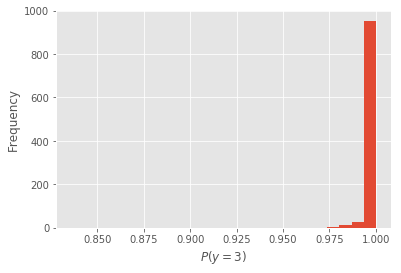

In [42]:
for i in range(5):
    plt.hist(y_hat_stocastic_test[i], bins=25)
    plt.xlabel("$P(y=3)$")
    plt.ylabel("Frequency")
    plt.show()

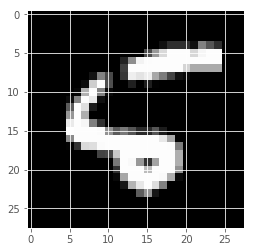

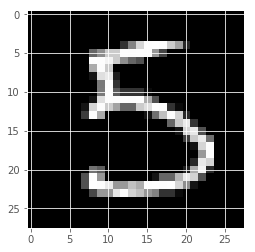

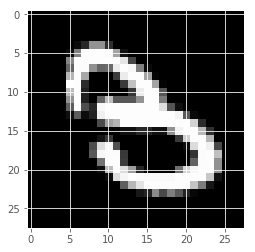

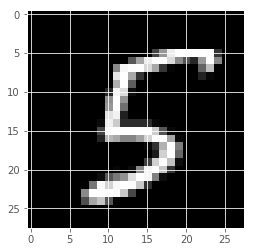

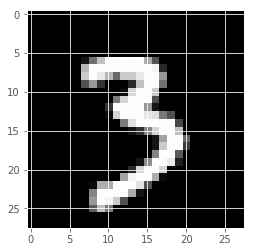

In [43]:
for i in range(5):
    plt.imshow(x_test[i].reshape(28,28), cmap="gray")
    plt.show()

Finalmente, vamos ver como são as maiores incertezas nos 4s não vistos durante o treino.

In [28]:
idx_uncertain = strange_analysis.sort_values(by="STD", ascending=False).head().index
strange_analysis.sort_values(by="STD", ascending=False).head()

,STD,VR,y_hat,y_true
1698,0.398348,0.495,0.497009,4
1637,0.388608,0.425,0.437609,4
1276,0.380184,0.440,0.555768,4
1622,0.376119,0.414,0.425444,4
1361,0.375846,0.433,0.569281,4


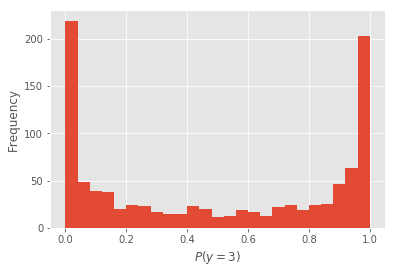

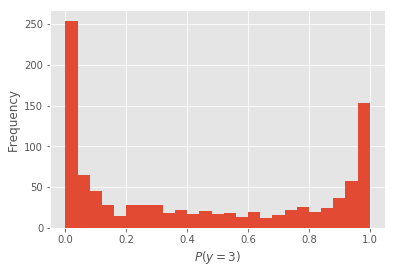

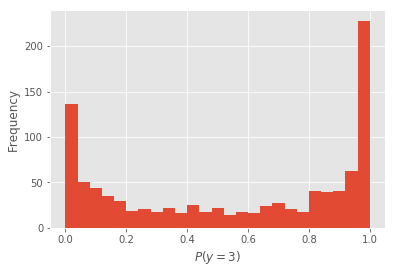

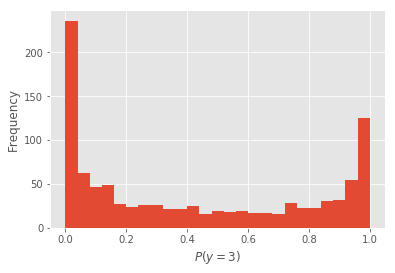

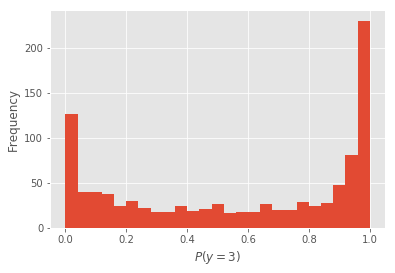

In [29]:
for i in idx_uncertain:
    plt.hist(y_hat_stocastic_strange[i], bins=25)
    plt.xlabel("$P(y=3)$")
    plt.ylabel("Frequency")
    plt.show()

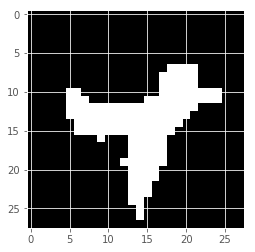

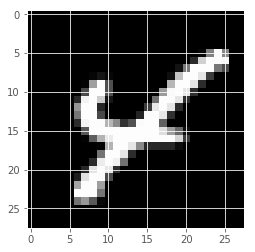

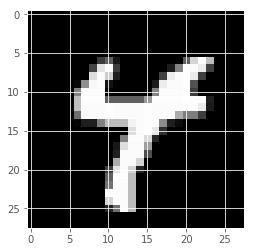

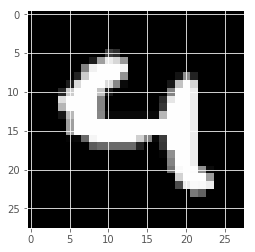

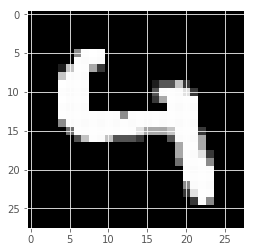

In [30]:
for i in idx_uncertain:
    plt.imshow(x_strange[i].reshape(28,28), cmap="gray")
    plt.show()

E agora, nos 5 primeiros quatros.

In [48]:
strange_analysis.head()

,STD,VR,y_hat,y_true
0,0.071620,0.005,0.975961,4
1,0.221695,0.084,0.120117,4
2,0.039524,0.001,0.990922,4
3,0.229735,0.131,0.787918,4
4,0.338248,0.486,0.478303,4


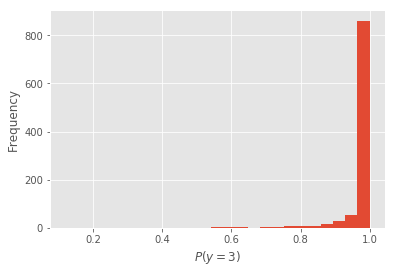

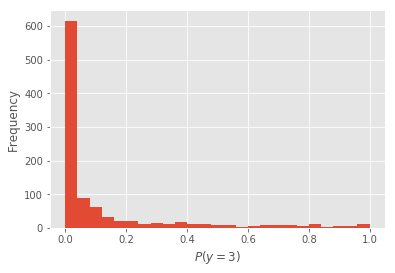

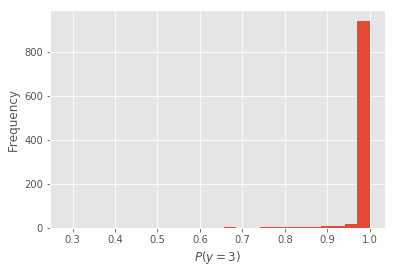

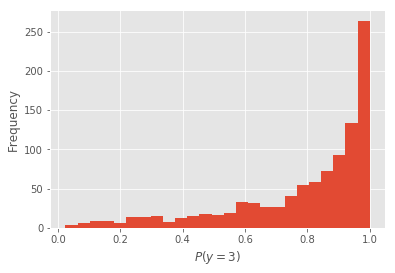

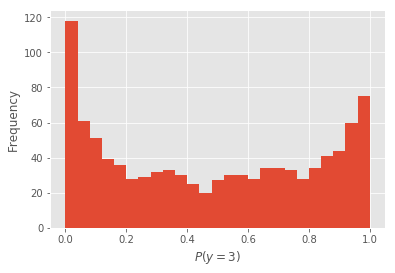

In [47]:
for i in range(5):
    plt.hist(y_hat_stocastic_strange[i], bins=25)
    plt.xlabel("$P(y=3)$")
    plt.ylabel("Frequency")
    plt.show()

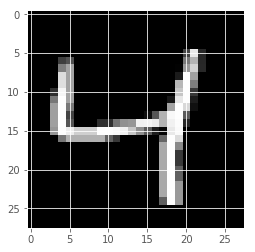

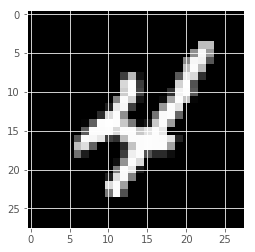

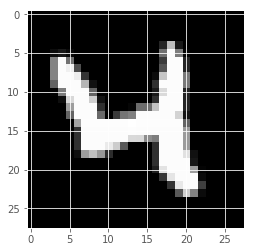

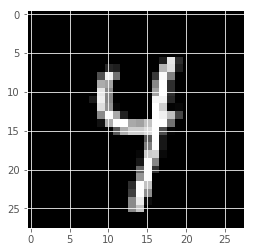

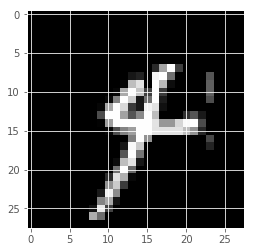

In [46]:
for i in range(5):
    plt.imshow(x_strange[i].reshape(28,28), cmap="gray")
    plt.show()